In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import logging
import plotly.express as px
import plotly.graph_objects as go

from math import pi

from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

from scipy.stats import skew, kurtosis

import json

import warnings


import os
import glob

from datetime import date, timedelta
import string
from functools import wraps
from timeit import default_timer
import math


In [3]:
def all_day_in_year(day=0, year=date.today().year):
    """Returns every occurrence of a specified weekday in a specified year"""

    # yyyy mm dd
    # 0 = mon 1 = tue 2 = wed 3 = thu 4 = fri 5 = sat 6 = sun
    dte = date(year, 1, 1)
    dte += timedelta(days=(day - dte.weekday()) % 7)
    while dte.year == year:
        yield dte
        dte += timedelta(days=7)


def files_in_path(path):
    return glob.glob(path)


def merge_csvs_in_path(path, glob_pattern="hot-100_*.csv", output_path='../data/billboard',
                       output_filename='merged_csv', index=False):
    files = glob.glob(f'{os.path.abspath(path)}/{glob_pattern}')
    full_df = None
    for file in files:
        full_df = pd.read_csv(file) if full_df is None else pd.concat([full_df, pd.read_csv(file)])
    full_df.to_csv(f"{output_path}/{output_filename}.csv", index=index)


def remove_punctuation(val: str) -> str:
    return val.translate(str.maketrans('', '', string.punctuation))


def mkdir(path: str) -> str:
    path = os.path.abspath(path)
    os.makedirs(path) if not os.path.exists(path) else None
    return path


def open_or_create_csv(path, cols):
    path = os.path.abspath(path)
    dir = os.sep.join(path.split(os.sep)[:-1])
    os.makedirs(dir) if not os.path.exists(dir) else None
    try:
        return pd.read_csv(path)
    except FileNotFoundError:
        pd.DataFrame(columns=cols).to_csv(path, index=False)
        return pd.read_csv(path)


def execution_time(round_to=2):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            st = default_timer()
            ret = func(*args, **kwargs)
            et = default_timer()
            print(f"\n func:{func.__name__} args:[{args}, {kwargs}] took: {round(et - st, round_to)} sec")
            return ret

        return wrapper

    return decorator


def sigmoid(x: int or float) -> int or float:
    return 1 / (1 + math.exp(-x))


def tanh(x: int or float) -> int or float:
    return (2 * sigmoid(2 * x)) - 1


def squiggle(rank_counts: np.ndarray or list, ranks: np.ndarray or list, scaled: bool = True) -> int or float:
    assert(len(rank_counts) == len(ranks))
    s = 0
    for i in range(len(rank_counts)):
        s += rank_counts[i] * ranks[i]
    return tanh(s) if scaled else s


def rank_score_basic(rank: int) -> float:
    return 1/rank


def rank_score_classic(peak: int, rank: int) -> float:
    base = 101
    peak = base - peak
    rank = base - rank
    return peak - rank + 1


def rank_score_01(peak: int, rank: int) -> float:
    try:
        return abs(1 / (1 / peak + 1 / rank - 1))
    except ZeroDivisionError:  # when peak rank and current rank are 2 this happens.
                               # take the middle of rank+1 and rank-1
        return (abs(1 / (1 / peak + 1 / (rank + 1) - 1)) + abs(1 / (1 / peak + 1 / (rank - 1) - 1))) / 2


def rank_score_02(peak: int, rank: int) -> float:
    return 1 / (peak + rank - 1)


def col_by_name(df: pd.DataFrame, col_name: str) -> int:
    return df.columns.get_loc(col_name)

In [4]:
warnings.filterwarnings('ignore')

In [5]:
random_state = 42
rng = np.random.default_rng(random_state)

In [6]:
billboard_df = pd.read_csv("hot-100_all.csv")
spotify_df = pd.read_csv("songs.csv")
audio_analysis_df = pd.read_csv("audio_features_full.csv")

In [7]:
billboard_df.drop(axis=1, inplace=True, labels=['image', 'artist'])
billboard_df['date'] = pd.to_datetime(billboard_df['date'])
spotify_df.drop(axis=1, inplace=True, labels=['spotify_name',
                                              'artist',
                                              'artist_genres',
                                              'spotify_id',
                                              'spotify_id',
                                              'spotify_uri',
                                              'spotify_external_url',
                                              'spotify_artist_popularity',
                                              'preview_url',
                                              'preview_url_audio',
                                              'full_audio',
                                              'full_audio_duration_s'
                                              ])
audio_analysis_df.drop(axis=1, inplace=True, labels=['name', 'tempo'])

In [8]:
songs_df = spotify_df.merge(audio_analysis_df, how='inner', on='billboard_name')
songs_df

,billboard_name,duration_ms,spotify_popularity,spotify_artist_popularity_mean,explicit,danceability,energy,key,loudness,mode,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,All I Want For Christmas Is You,241106.0,69.0,81.000000,False,0.336,0.627,7.0,-7.463,1.0,...,1.619618,99.735660,-3.865835,99.024666,2.729783,112.219580,-7.488522,122.569650,2.323859,141.572560
1,Rockin' Around The Christmas Tree,126266.0,62.0,59.000000,False,0.589,0.472,8.0,-8.749,1.0,...,-1.039626,78.420586,-4.437555,55.536427,3.890496,70.359543,0.014326,77.899239,6.889563,93.610161
2,Jingle Bell Rock,130973.0,62.0,50.000000,False,0.754,0.424,2.0,-8.463,1.0,...,1.430321,58.685158,-4.030815,67.332291,1.802275,58.469532,-5.335912,53.423290,0.133941,58.774597
3,A Holly Jolly Christmas,135533.0,54.0,48.000000,False,0.683,0.375,0.0,-13.056,1.0,...,-1.355817,60.197350,-6.695084,52.782772,-4.325858,66.221947,-3.533713,50.849602,-1.266797,90.991325
4,Circles,215280.0,86.0,91.000000,False,0.695,0.762,0.0,-3.497,1.0,...,2.563944,78.141319,-12.359889,83.661438,4.207565,65.643173,-5.280680,54.441185,-0.751733,59.799530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,Christmas Isn't Canceled (Just You),231549.0,41.0,77.000000,False,0.580,0.789,1.0,-4.918,0.0,...,5.321839,70.412506,1.213545,77.698616,4.693950,85.284431,-2.604682,76.687698,5.805956,77.433144
1419,Moved To Miami,222225.0,66.0,88.500000,True,0.717,0.444,1.0,-11.126,1.0,...,4.598643,180.801086,-4.373017,110.878738,4.545245,111.550697,4.918246,63.780304,8.114554,75.806396
1420,Hibachi,170413.0,69.0,86.333333,True,0.681,0.522,5.0,-8.740,0.0,...,8.091636,79.854568,-1.646704,123.382797,5.309008,98.507568,0.213412,80.767159,2.804790,73.490234
1421,Thailand,200958.0,70.0,84.000000,True,0.875,0.478,7.0,-10.562,1.0,...,10.420262,91.743813,-2.071233,75.112267,8.341298,97.730263,-0.260812,69.875168,1.959964,62.722679


In [9]:
songs_df.describe()

,duration_ms,spotify_popularity,spotify_artist_popularity_mean,danceability,energy,key,loudness,mode,speechiness,acousticness,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,...,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,200696.557976,67.404076,83.302977,0.666045,0.622016,5.153197,-6.747289,0.622628,0.139837,0.223816,...,2.398114,84.513799,-3.647905,82.115186,2.668189,80.818220,-2.539943,79.075432,1.677588,80.371770
std,50770.975125,17.661345,12.018877,0.151579,0.162841,3.600340,2.579960,0.484900,0.125819,0.253148,...,3.631675,24.471115,3.398574,24.637780,3.253561,24.665541,3.023733,24.767819,3.186344,26.740148
min,32000.000000,0.000000,0.000000,0.150000,0.007600,0.000000,-33.663000,0.000000,0.023200,0.000003,...,-13.240079,32.670311,-18.392536,31.161884,-10.105947,31.325922,-14.229393,28.560005,-13.992401,28.597084
25%,170322.000000,64.000000,78.000000,0.570000,0.525000,1.000000,-7.841500,0.000000,0.042800,0.031550,...,0.246056,68.009289,-5.805181,65.208897,0.716595,64.160015,-4.468847,62.009989,-0.239844,61.936447
50%,195428.000000,70.000000,86.000000,0.680000,0.633000,5.000000,-6.360000,1.000000,0.079800,0.121000,...,2.442511,81.295982,-3.595455,78.402687,2.753472,77.774918,-2.510375,75.437561,1.633557,75.101379
75%,223599.000000,77.000000,91.000000,0.776000,0.733500,8.000000,-5.077500,1.000000,0.218000,0.321500,...,4.722763,98.500587,-1.416037,94.838615,4.810408,93.118820,-0.625247,91.067223,3.652482,93.510078
max,613026.000000,95.000000,100.000000,0.965000,0.984000,11.000000,-1.321000,1.000000,0.699000,0.995000,...,13.629806,207.025589,6.795540,219.371109,12.521308,229.869766,7.686097,229.040588,14.772246,226.710175


In [10]:
songs_df.isna().sum()

billboard_name                    0
duration_ms                       0
spotify_popularity                0
spotify_artist_popularity_mean    0
explicit                          0
                                 ..
mfcc18_var                        0
mfcc19_mean                       0
mfcc19_var                        0
mfcc20_mean                       0
mfcc20_var                        0
Length: 75, dtype: int64

In [11]:
songs_df = pd.get_dummies(songs_df, prefix=['explicit'], columns=['explicit'])

adding features

In [12]:
def spotify_audio_analysis(filename):
    file = open(filename)
    analysis_json = json.load(file)
    file.close()
    timbre_coefs = np.arange(1, 13)
    bars = analysis_json['bars']
    beats = analysis_json['beats']
    sections = analysis_json['sections']
    segments = analysis_json['segments']
    tatums = analysis_json['tatums']

    return pd.DataFrame(data={
        # "time_signature": [analysis_json['track']['time_signature']],
        # "mode": [analysis_json['track']['mode']],
        "num_bars": len(bars),
        "mean_bar_duration": np.mean([b['duration'] for b in bars]),
        "var_bar_duration": np.var([b['duration'] for b in bars]),
        "num_beats": len(beats),
        "mean_beat_duration": np.mean([b['duration'] for b in beats]),
        "var_beat_duration": np.var([b['duration'] for b in beats]),
        "num_sections": len(sections),
        "mean_section_duration": np.mean([s['duration'] for s in sections]),
        "var_section_duration": np.var([s['duration'] for s in sections]),
        "mean_section_tempo": np.mean([s['tempo'] for s in sections]),
        "var_section_tempo": np.var([s['tempo'] for s in sections]),
        "mean_section_loudness": np.mean([s['loudness'] for s in sections]),
        "var_section_loudness": np.var([s['loudness'] for s in sections]),
        # other section stuff
        "num_segments": len(segments),
        "mean_segment_duration": np.mean([s['duration'] for s in segments]),
        "var_segment_duration": np.var([s['duration'] for s in segments]),
        "mean_segment_loudness_start": np.mean([s['loudness_start'] for s in segments]),
        "var_segment_loudness_start": np.var([s['loudness_start'] for s in segments]),
        "mean_segment_loudness_max": np.mean([s['loudness_max'] for s in segments]),
        "var_segment_loudness_max": np.var([s['loudness_max'] for s in segments]),
        "mean_segment_loudness_max_time": np.mean([s['loudness_max_time'] for s in segments]),
        "var_segment_loudness_max_time": np.var([s['loudness_max_time'] for s in segments]),
        "mean_segment_loudness_end": np.mean([s['loudness_end'] for s in segments]),
        "var_segment_loudness_end": np.var([s['loudness_end'] for s in segments]),
        "mean_segment_loudness_start_max_diff": np.mean([abs(s['loudness_start'] - s['loudness_max']) for s in segments]),
        "var_segment_loudness_start_max_diff": np.var([abs(s['loudness_start'] - s['loudness_max']) for s in segments]),
        "mean_segment_loudness_start_end_diff": np.mean([abs(s['loudness_start'] - s['loudness_end']) for s in segments]),
        "var_segment_loudness_start_end_diff": np.var([abs(s['loudness_start'] - s['loudness_end']) for s in segments]),
        "mean_segment_loudness_max_end_diff": np.mean([abs(s['loudness_max'] - s['loudness_end']) for s in segments]),
        "var_segment_loudness_max_end_diff": np.var([abs(s['loudness_max'] - s['loudness_end']) for s in segments]),
        "mean_segment_num_pitches": np.mean([len(s['pitches']) for s in segments]),
        "var_segment_num_pitches": np.var([len(s['pitches']) for s in segments]),
        "mean_segment_num_pure_pitches": np.mean([len(np.array(s['pitches'])[np.array(s['pitches']) > 0.5]) for s in segments]),
        "var_segment_num_pure_pitches": np.var([len(np.array(s['pitches'])[np.array(s['pitches']) > 0.5]) for s in segments]),
        "mean_segment_timbre": np.mean([np.dot(s['timbre'], timbre_coefs) for s in segments]),
        "var_segment_timbre": np.var([np.dot(s['timbre'], timbre_coefs) for s in segments]),
        "num_tatums": len(tatums),
        "mean_tatum_duration": np.mean([t['duration'] for t in tatums]),
        "var_tatum_duration": np.var([t['duration'] for t in tatums]),
    }, index=[0])

In [13]:
aa = pd.DataFrame()
for i in range(len(songs_df)):
    aa = pd.concat([aa, spotify_audio_analysis("audio_analysis/" + spotify_df['audio_analysis_file'].iloc[0])], axis=0)
aa.reset_index(inplace=True)
songs_df = pd.concat([songs_df, aa], axis=1)
songs_df.drop(labels='index', axis=1, inplace=True)

In [14]:
songs_df.describe()

,duration_ms,spotify_popularity,spotify_artist_popularity_mean,danceability,energy,key,loudness,mode,speechiness,acousticness,...,var_segment_loudness_max_end_diff,mean_segment_num_pitches,var_segment_num_pitches,mean_segment_num_pure_pitches,var_segment_num_pure_pitches,mean_segment_timbre,var_segment_timbre,num_tatums,mean_tatum_duration,var_tatum_duration
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,...,1.423000e+03,1423.0,1423.0,1.423000e+03,1.423000e+03,1.423000e+03,1.423000e+03,1423.0,1.423000e+03,1.423000e+03
mean,200696.557976,67.404076,83.302977,0.666045,0.622016,5.153197,-6.747289,0.622628,0.139837,0.223816,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
std,50770.975125,17.661345,12.018877,0.151579,0.162841,3.600340,2.579960,0.484900,0.125819,0.253148,...,8.316273e-13,0.0,0.0,3.331840e-14,6.663680e-14,3.923575e-12,1.030638e-08,0.0,2.832064e-15,7.201633e-17
min,32000.000000,0.000000,0.000000,0.150000,0.007600,0.000000,-33.663000,0.000000,0.023200,0.000003,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
25%,170322.000000,64.000000,78.000000,0.570000,0.525000,1.000000,-7.841500,0.000000,0.042800,0.031550,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
50%,195428.000000,70.000000,86.000000,0.680000,0.633000,5.000000,-6.360000,1.000000,0.079800,0.121000,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
75%,223599.000000,77.000000,91.000000,0.776000,0.733500,8.000000,-5.077500,1.000000,0.218000,0.321500,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
max,613026.000000,95.000000,100.000000,0.965000,0.984000,11.000000,-1.321000,1.000000,0.699000,0.995000,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03


In [15]:
songs_df.head()

,billboard_name,duration_ms,spotify_popularity,spotify_artist_popularity_mean,danceability,energy,key,loudness,mode,speechiness,...,var_segment_loudness_max_end_diff,mean_segment_num_pitches,var_segment_num_pitches,mean_segment_num_pure_pitches,var_segment_num_pure_pitches,mean_segment_timbre,var_segment_timbre,num_tatums,mean_tatum_duration,var_tatum_duration
0,All I Want For Christmas Is You,241106.0,69.0,81.0,0.336,0.627,7.0,-7.463,1.0,0.0384,...,45.33173,12.0,0.0,2.263092,2.966942,275.467224,356469.006977,1106,0.215763,0.00616
1,Rockin' Around The Christmas Tree,126266.0,62.0,59.0,0.589,0.472,8.0,-8.749,1.0,0.0502,...,45.33173,12.0,0.0,2.263092,2.966942,275.467224,356469.006977,1106,0.215763,0.00616
2,Jingle Bell Rock,130973.0,62.0,50.0,0.754,0.424,2.0,-8.463,1.0,0.0363,...,45.33173,12.0,0.0,2.263092,2.966942,275.467224,356469.006977,1106,0.215763,0.00616
3,A Holly Jolly Christmas,135533.0,54.0,48.0,0.683,0.375,0.0,-13.056,1.0,0.0303,...,45.33173,12.0,0.0,2.263092,2.966942,275.467224,356469.006977,1106,0.215763,0.00616
4,Circles,215280.0,86.0,91.0,0.695,0.762,0.0,-3.497,1.0,0.0395,...,45.33173,12.0,0.0,2.263092,2.966942,275.467224,356469.006977,1106,0.215763,0.00616


pop metrics


In [16]:
def popularity_metrics(df, score_type='basic'):
    metrics = ['peak_rank', 'lifetime_peak_rank', 'debut_rank', 'sensationality', 'avg_rank_score', 'std_rank_score', 'time_on_chart', 'num_occurrences', 'rank_sum', 'skewness', 'kurtosis', 'spotify_popularity']
    metric_vals = []

    for i in range(len(df)):
        song = df.iloc[i]
        billboard_entries = billboard_df[billboard_df['title'] == song['billboard_name']].sort_values(by='date')
        value_counts = billboard_entries['rank'].value_counts()
        ranks = value_counts.index
        rank_counts = value_counts.values


        # max rank
        peak = min(ranks)
        if score_type == 'classic':
            ranks = [rank_score_classic(peak, ra) for ra in ranks]
        elif score_type == 'score_01':
            ranks = [rank_score_01(peak, ra) for ra in ranks]
        elif score_type == 'score_02':
            ranks = [rank_score_02(peak, ra) for ra in ranks]
        else:
            ranks = [rank_score_basic(ra) for ra in ranks]

        # sensationality
        sensation = squiggle(rank_counts, ranks, scaled=True)

        # mean rank
        avg_rank = np.mean(ranks)

        # rank std
        std_rank = np.std(ranks)

        # length
        time_on_chart = np.max(billboard_entries['weeks'])

        # lifetime_peak
        lifetime_peak = np.max(billboard_entries['peakPos'])

        # debut rank
        debut_rank = billboard_entries['rank'].iloc[0]

        # number of occurrences
        num_occurrences = len(billboard_entries)

        rank_sum = sum(ranks)

        skewness = skew(ranks)

        kurt = kurtosis(ranks)

        metric_vals.append([peak, debut_rank, lifetime_peak, sensation, avg_rank, std_rank, time_on_chart, num_occurrences, rank_sum, skewness, kurt, song['spotify_popularity']])

    return pd.DataFrame(data=metric_vals, columns=metrics)

In [17]:
pop_metrics = popularity_metrics(songs_df, 'basic')
pop_metrics.describe()

,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.00000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,50.872804,60.858749,59.452565,0.173917,0.025285,0.015060,8.41532,7.326072,0.221581,0.450854,-1.188760,67.404076
std,28.872677,28.879139,29.739192,0.264423,0.031150,0.045298,10.98796,9.710895,0.485595,0.822457,2.763996,17.661345
min,1.000000,1.000000,1.000000,0.010000,0.010000,0.000000,1.00000,1.000000,0.010000,-1.361391,-3.000000,0.000000
25%,26.000000,39.000000,36.500000,0.014492,0.012616,0.000000,1.00000,1.000000,0.014493,0.000000,-3.000000,64.000000
50%,53.000000,66.000000,65.000000,0.040918,0.015764,0.001422,2.00000,2.000000,0.040831,0.000000,-2.000000,70.000000
75%,76.000000,86.000000,86.000000,0.221774,0.023810,0.008715,14.00000,11.000000,0.196657,0.701393,-0.694673,77.000000
max,100.000000,100.000000,100.000000,1.000000,0.409608,0.424401,90.00000,87.000000,3.697960,4.800006,22.324941,95.000000


In [18]:
pop_metrics = popularity_metrics(songs_df, 'classic')
pop_metrics.describe()

,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.00000,1423.000000,1423.00000,1423.000000,1423.000000,1423.000000
mean,50.872804,60.858749,59.452565,0.898278,14.673815,9.749975,8.41532,7.326072,146.21785,0.032422,-1.819822,67.404076
std,28.872677,28.879139,29.739192,0.117932,15.124559,10.401953,10.98796,9.710895,217.31022,0.468476,1.306573,17.661345
min,1.000000,1.000000,1.000000,0.761594,1.000000,0.000000,1.00000,1.000000,1.00000,-2.398583,-3.000000,0.000000
25%,26.000000,39.000000,36.500000,0.761594,1.000000,0.000000,1.00000,1.000000,1.00000,0.000000,-3.000000,64.000000
50%,53.000000,66.000000,65.000000,1.000000,10.857143,7.537241,2.00000,2.000000,38.00000,0.000000,-2.000000,70.000000
75%,76.000000,86.000000,86.000000,1.000000,25.657143,17.808576,14.00000,11.000000,232.00000,0.000000,-1.025932,77.000000
max,100.000000,100.000000,100.000000,1.000000,65.333333,40.000000,90.00000,87.000000,1252.00000,2.719581,7.127719,95.000000


In [19]:
pop_metrics = popularity_metrics(songs_df, 'score_01')
pop_metrics.describe()

,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.00000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,50.872804,60.858749,59.452565,0.900328,1.780139,0.575463,8.41532,7.326072,17.299562,0.415488,-1.320215,67.404076
std,28.872677,28.879139,29.739192,0.108910,4.671507,3.534214,10.98796,9.710895,73.512941,0.762767,2.497012,17.661345
min,1.000000,1.000000,1.000000,0.770033,1.020408,0.000000,1.00000,1.000000,1.020408,-1.360677,-3.000000,0.000000
25%,26.000000,39.000000,36.500000,0.773848,1.026667,0.000000,1.00000,1.000000,1.029851,0.000000,-3.000000,64.000000
50%,53.000000,66.000000,65.000000,0.970869,1.036364,0.001515,2.00000,2.000000,2.103609,0.000000,-2.000000,70.000000
75%,76.000000,86.000000,86.000000,1.000000,1.066667,0.009947,14.00000,11.000000,10.965784,0.687990,-0.715733,77.000000
max,100.000000,100.000000,100.000000,1.000000,65.333333,37.124415,90.00000,87.000000,927.000000,4.636364,21.196639,95.000000


In [20]:
pop_metrics = popularity_metrics(songs_df, 'score_02')
pop_metrics.describe()

,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.00000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,50.872804,60.858749,59.452565,0.132618,0.016987,0.011042,8.41532,7.326072,0.169956,0.345212,-1.374249,67.404076
std,28.872677,28.879139,29.739192,0.239601,0.030406,0.043514,10.98796,9.710895,0.450653,0.750308,2.464867,17.661345
min,1.000000,1.000000,1.000000,0.005025,0.005025,0.000000,1.00000,1.000000,0.005025,-1.474878,-3.000000,0.000000
25%,26.000000,39.000000,36.500000,0.007299,0.006536,0.000000,1.00000,1.000000,0.007299,0.000000,-3.000000,64.000000
50%,53.000000,66.000000,65.000000,0.022614,0.008691,0.000406,2.00000,2.000000,0.022286,0.000000,-2.000000,70.000000
75%,76.000000,86.000000,86.000000,0.135852,0.014067,0.003357,14.00000,11.000000,0.120634,0.470999,-0.873880,77.000000
max,100.000000,100.000000,100.000000,1.000000,0.409608,0.424401,90.00000,87.000000,3.697960,4.443465,19.928467,95.000000


In [21]:
data_df = songs_df.copy()
song_billboard_names = data_df.pop('billboard_name')
song_audio_analysis_files = data_df.pop('audio_analysis_file')
data_df[data_df.columns] = StandardScaler().fit_transform(data_df)
data_df

,duration_ms,spotify_popularity,spotify_artist_popularity_mean,danceability,energy,key,loudness,mode,speechiness,acousticness,...,var_segment_loudness_max_end_diff,mean_segment_num_pitches,var_segment_num_pitches,mean_segment_num_pure_pitches,var_segment_num_pure_pitches,mean_segment_timbre,var_segment_timbre,num_tatums,mean_tatum_duration,var_tatum_duration
0,0.796196,0.090394,-0.191681,-2.178146,0.030618,0.513133,-0.277509,0.778521,-0.806495,-0.236372,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
1,-1.466521,-0.306091,-2.022778,-0.508462,-0.921567,0.790982,-0.776142,0.778521,-0.712676,1.541868,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
2,-1.373778,-0.306091,-2.771863,0.580463,-1.216437,-0.876113,-0.665248,0.778521,-0.823191,1.656466,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
3,-1.283932,-0.759217,-2.938327,0.111895,-1.517450,-1.431812,-2.446135,0.778521,-0.870895,1.403561,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
4,0.287341,1.053287,0.640636,0.191090,0.859939,-1.431812,1.260264,0.778521,-0.797749,-0.125726,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,0.607892,-1.495546,-0.524607,-0.567858,1.025804,-1.153963,0.709287,-1.284487,-0.748454,-0.714917,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
1419,0.424180,-0.079528,0.432557,0.336280,-1.093574,-1.153963,-1.697798,0.778521,0.319326,-0.806990,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
1420,-0.596684,0.090394,0.252222,0.098696,-0.614410,-0.042566,-0.772652,-1.284487,1.297263,-0.808966,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
1421,0.005151,0.147035,0.058014,1.379008,-0.884708,0.513133,-1.479113,0.778521,0.621453,-0.856109,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0


<AxesSubplot:xlabel='sensationality', ylabel='Count'>

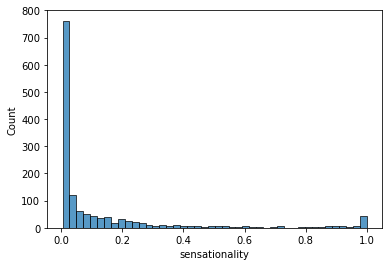

In [22]:
sns.histplot(pop_metrics['sensationality'])

In [23]:
pop_metrics.head()

,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
0,1,1,1,0.999999,0.270183,0.316913,50,14,2.161467,1.395650,0.673814,69.0
1,2,2,83,0.991834,0.095308,0.107601,44,17,1.048391,1.137687,-0.206880,62.0
2,3,3,3,0.916952,0.107502,0.057082,41,12,0.860014,0.154038,-1.314696,62.0
3,4,4,4,0.789038,0.082270,0.039804,25,11,0.658162,0.146166,-1.560483,54.0
4,1,5,94,0.999999,0.153094,0.215097,61,47,2.908793,3.182407,9.711951,86.0


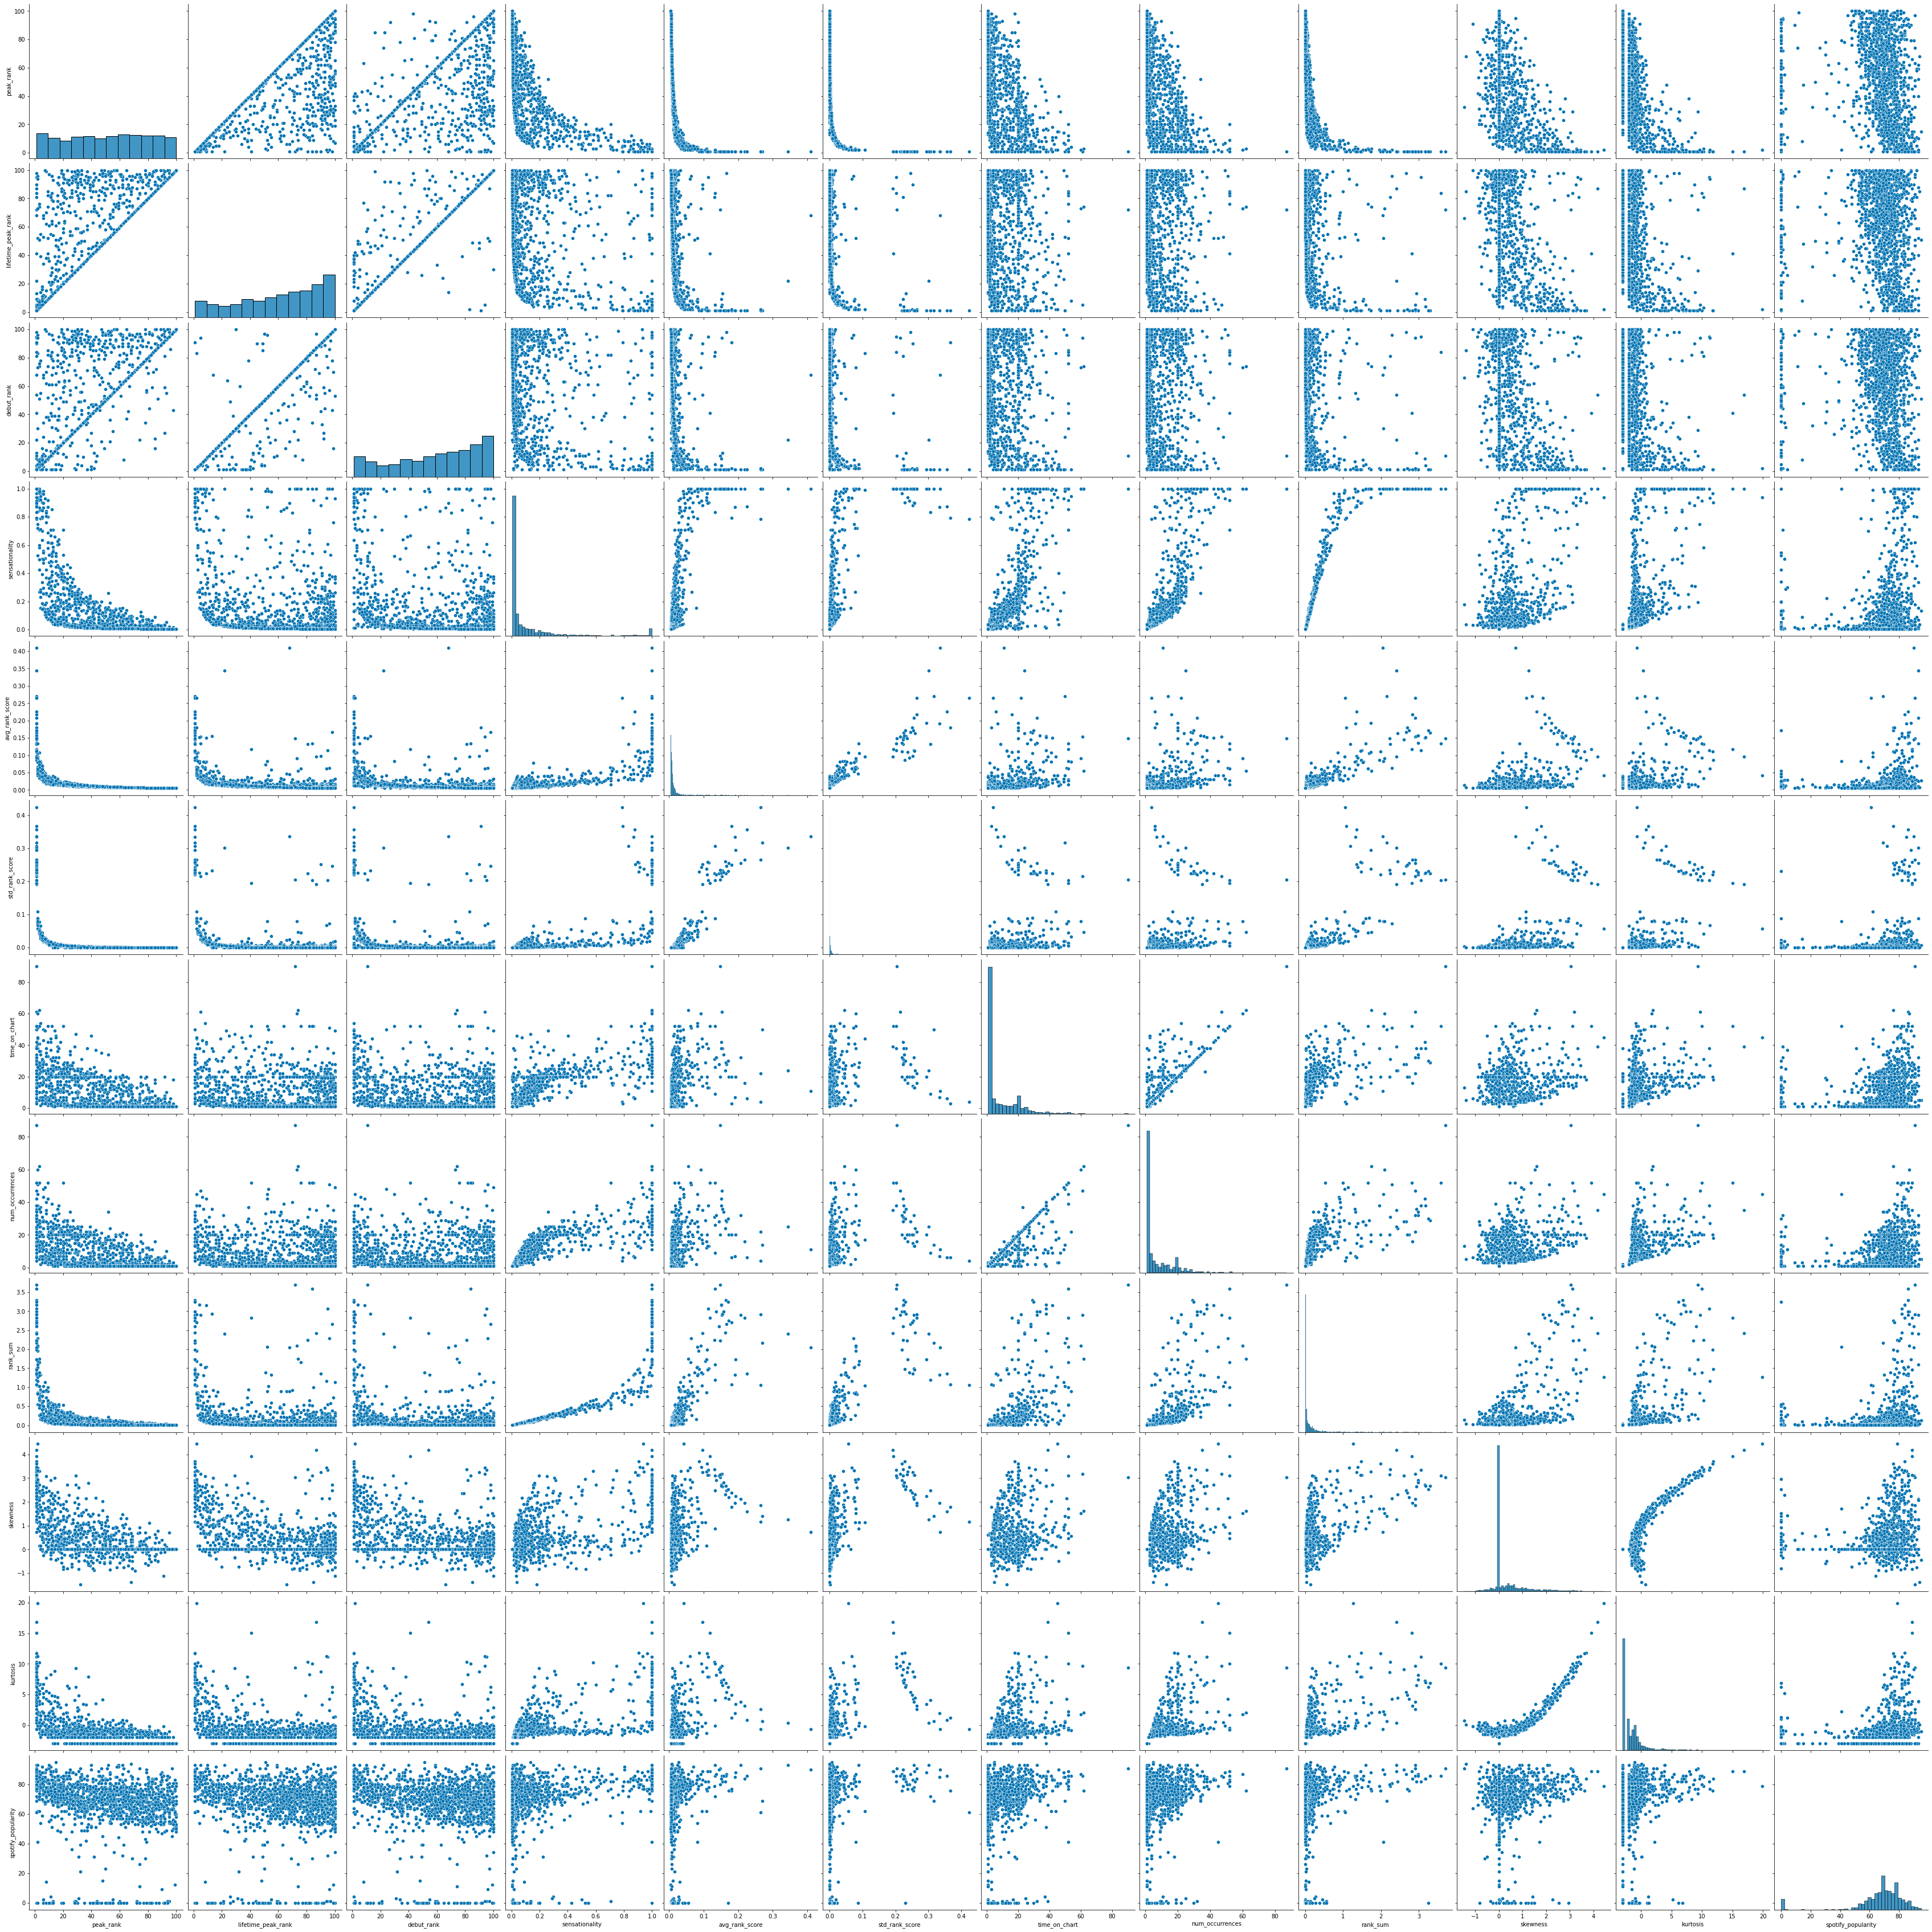

In [32]:
sns.set_palette('colorblind')
sns.pairplot(data=pop_metrics, height=4)

In [35]:
tdb = 1 + (pop_metrics - pop_metrics.min()) * 9 / (pop_metrics.max() - pop_metrics.min())

In [36]:
tdb

,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
0,1.000000,1.000000,1.000000,9.999989,6.898483,7.720575,5.955056,2.360465,6.255433,5.365200,2.442065,7.536842
1,1.090909,1.090909,8.454545,9.926131,3.008362,3.281836,5.348315,2.674419,3.542773,4.972917,2.096370,6.873684
2,1.181818,1.181818,1.181818,9.248795,3.279607,2.210505,5.044944,2.151163,3.083681,3.477086,1.661524,6.873684
3,1.272727,1.272727,1.272727,8.091749,2.718329,1.844093,3.426966,2.046512,2.591751,3.465114,1.565046,6.115789
4,1.000000,1.363636,9.454545,9.999993,4.293821,5.561417,7.067416,5.813953,8.076731,8.082314,5.989761,9.147368
...,...,...,...,...,...,...,...,...,...,...,...,...
1418,8.090909,8.090909,8.090909,1.012159,1.029904,1.000000,1.000000,1.000000,1.003276,3.242841,1.000000,4.884211
1419,8.636364,8.636364,8.636364,1.008069,1.019843,1.000000,1.000000,1.000000,1.002174,3.242841,1.000000,7.252632
1420,9.181818,9.181818,9.181818,1.004520,1.011117,1.000000,1.000000,1.000000,1.001218,3.242841,1.000000,7.536842
1421,9.545455,9.545455,9.545455,1.002405,1.005915,1.000000,1.000000,1.000000,1.000648,3.242841,1.000000,7.631579


In [37]:
tdb.drop(labels='lifetime_peak_rank', axis=1, inplace=True)

In [38]:
tdb.drop(labels='num_occurrences', axis=1, inplace=True)

In [39]:
tdb.drop(labels='rank_sum', axis=1, inplace=True)

In [40]:
tdb['song_name'] = songs_df['billboard_name']

In [41]:
tdb = tdb[ ['song_name'] + [ col for col in tdb.columns if col != 'song_name' ] ]

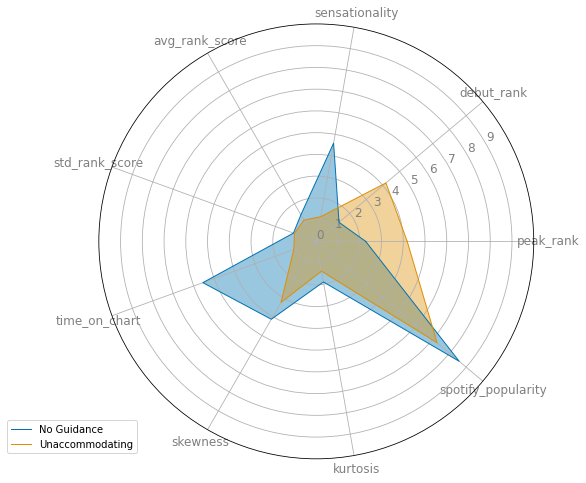

In [49]:
# obtain df information
categories = list(tdb)[1:]
#categories = ['peak_rank', 'lifetime_peak_rank', 'debut_rank', 'sensationality', 'avg_rank_score']
values = tdb.mean().values.flatten().tolist()
values += values[:1] # repeat the first value to close the circular graph
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

# define plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                        subplot_kw=dict(polar=True))
plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.yticks(np.arange(0, 10, 1),
           color='grey', size=12)
plt.ylim(0, 10)
ax.set_rlabel_position(30)

# draw radar-chart:
#for i in range(len(tdb)):
for i in (24, 150):
#for i in (3):
    val_c1 = tdb.loc[i].drop('song_name').values.flatten().tolist()
    val_c1 += val_c1[:1]
    ax.plot(angles, val_c1, linewidth=1, linestyle='solid',
            label=tdb.loc[i]["song_name"])
    ax.fill(angles, val_c1, alpha=0.4)

# add legent and show plot
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

Text(0.5, 1.0, 'spotify_popularity')

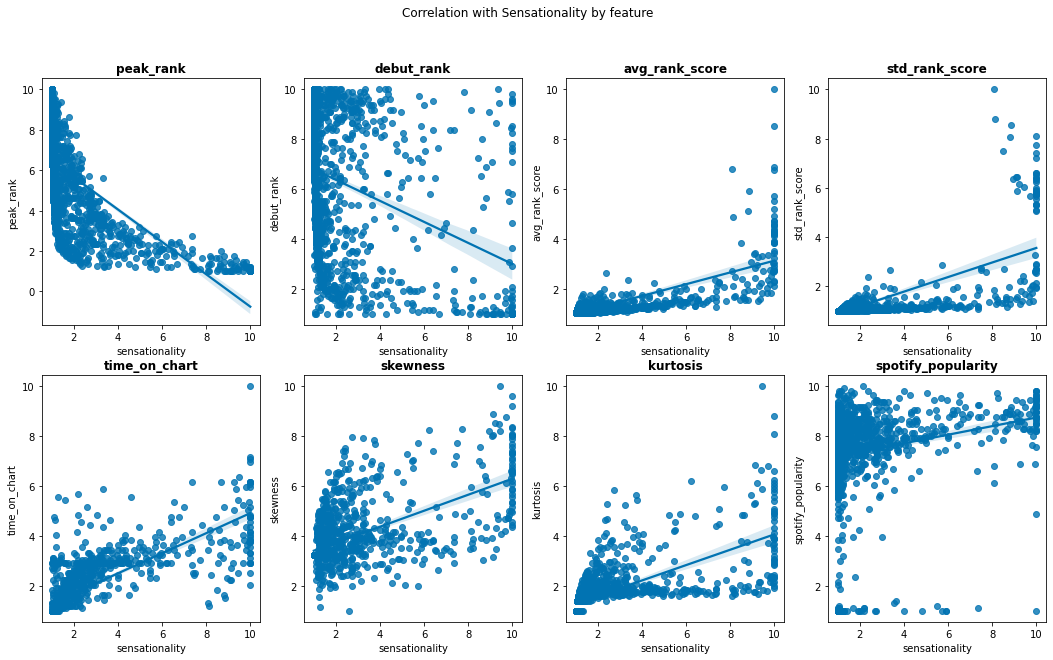

In [45]:
xaxis = tdb["sensationality"]
#yaxis = [tdb['peak_rank'],tdb['lifetime_peak_rank'],tdb['debut_rank'],tdb['avg_rank_score'],tdb['std_rank_score'],
#tdb['time_on_chart'],tdb['num_occurrences'],tdb['rank_sum'],tdb['skewness'],tdb['kurtosis'],tdb['spotify_popularity']]

yaxis = [tdb['peak_rank'],tdb['debut_rank'],tdb['avg_rank_score'],tdb['std_rank_score'],
tdb['time_on_chart'],tdb['skewness'],tdb['kurtosis'],tdb['spotify_popularity']]


fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle('Correlation with Sensationality by feature')

#a = 0
#b = 0
#for i in range (0,3):
#   sns.regplot(x=xaxis, y=yaxis[i], ax=axes[a,b])
#   axes[a,b].set_title(yaxis[i])
    
sns.regplot(x=xaxis, y=yaxis[0], ax=axes[0,0])
axes[0,0].set_title(yaxis[0].name,fontweight="bold")

sns.regplot(x=xaxis, y=yaxis[1], ax=axes[0,1])
axes[0,1].set_title(yaxis[1].name,fontweight="bold")

sns.regplot(x=xaxis, y=yaxis[2], ax=axes[0,2])
axes[0,2].set_title(yaxis[2].name,fontweight="bold")

sns.regplot(x=xaxis, y=yaxis[3], ax=axes[0,3])
axes[0,3].set_title(yaxis[3].name,fontweight="bold")

sns.regplot(x=xaxis, y=yaxis[4], ax=axes[1,0])
axes[1,0].set_title(yaxis[4].name,fontweight="bold")

sns.regplot(x=xaxis, y=yaxis[5], ax=axes[1,1])
axes[1,1].set_title(yaxis[5].name,fontweight="bold")

sns.regplot(x=xaxis, y=yaxis[6], ax=axes[1,2])
axes[1,2].set_title(yaxis[6].name,fontweight="bold")

sns.regplot(x=xaxis, y=yaxis[7], ax=axes[1,3])
axes[1,3].set_title(yaxis[7].name,fontweight="bold")


In [46]:
corr = tdb.corr()

corr.style.background_gradient(cmap='coolwarm')

,peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,skewness,kurtosis,spotify_popularity
peak_rank,1.000000,0.722355,-0.662378,-0.505181,-0.406338,-0.588869,-0.554601,-0.600128,-0.183913
debut_rank,0.722355,1.000000,-0.337793,-0.384334,-0.304498,-0.240786,-0.423265,-0.384115,-0.090160
sensationality,-0.662378,-0.337793,1.000000,0.756798,0.694864,0.784088,0.608493,0.689415,0.222492
avg_rank_score,-0.505181,-0.384334,0.756798,1.000000,0.931079,0.428278,0.511578,0.513133,0.159145
std_rank_score,-0.406338,-0.304498,0.694864,0.931079,1.000000,0.344999,0.572118,0.576533,0.147854
time_on_chart,-0.588869,-0.240786,0.784088,0.428278,0.344999,1.000000,0.435233,0.589978,0.200909
skewness,-0.554601,-0.423265,0.608493,0.511578,0.572118,0.435233,1.000000,0.885427,0.174177
kurtosis,-0.600128,-0.384115,0.689415,0.513133,0.576533,0.589978,0.885427,1.000000,0.207554
spotify_popularity,-0.183913,-0.090160,0.222492,0.159145,0.147854,0.200909,0.174177,0.207554,1.000000


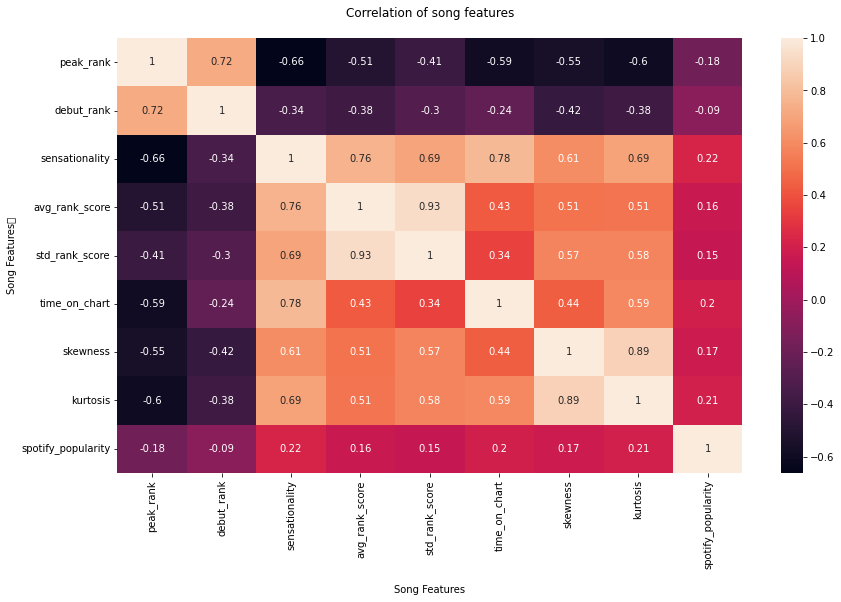

In [47]:
plt.figure(figsize = (14,8))
hm = sns.heatmap(tdb.corr(), annot= True)
hm.set(xlabel='\nSong Features', ylabel='Song Features\t', title = "Correlation of song features\n")
plt.show()

In [77]:
# Overlay 2 histograms to compare them
def overlaid_histogram(data1, data2, data1_name="", data1_color="#539caf", data2_name="", data2_color="#7663b0", x_label="", y_label="", title="", n_bins = 0):
    # Set the bounds for the bins so that the two distributions are fairly compared
    max_nbins = 10
    data_range = [min(min(data1), min(data2)), max(max(data1), max(data2))]
    binwidth = (data_range[1] - data_range[0]) / max_nbins


    if n_bins == 0:
        bins = np.arange(data_range[0], data_range[1] + binwidth, binwidth)
    else: 
        bins = n_bins

    # Create the plot
    
    _, ax = plt.subplots(figsize=(15,9))
    ax.hist(data1, bins = bins, color = data1_color, alpha = 1, label = data1_name)
    ax.hist(data2, bins = bins, color = data2_color, alpha = 0.5, label = data2_name)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.legend(loc = 'best')

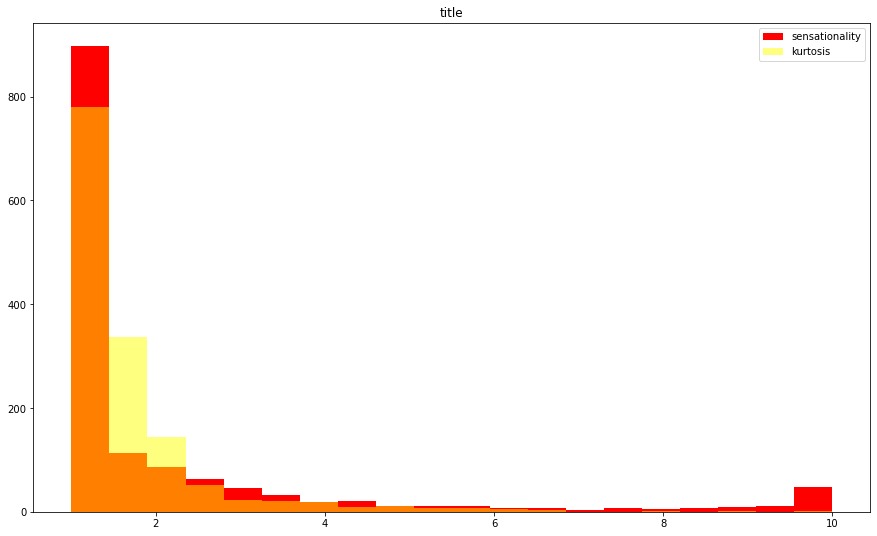

In [79]:

overlaid_histogram(tdb['sensationality'],tdb['kurtosis'],'sensationality','red','kurtosis','yellow',"","",'title',20)